##Importing necessary packages.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from tensorflow import keras
from tensorflow.keras import layers
import os

11493376/11490434 [==============================] - 0s 0us/step


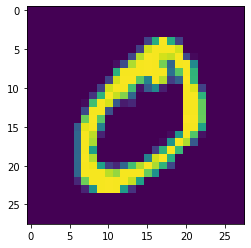

In [2]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_images[1])

In [3]:
BUFFER_SIZE = train_images.shape[0]

#Creating dataset with 9 as the only image

In [4]:
new_images = []
new_labels = []
for i in range(60000):
    if train_labels[i] == 9:
        new_images.append(train_images[i])
        new_labels.append(train_labels[i])
new_train_images = np.array(new_images)
new_train_labels = np.array(new_labels)

In [5]:
test_images = []
test_labels = []
for i in range(len(test_labels)):
    if test_labels[i] == 9:
        test_images.append(test_images[i])
        test_labels.append(test_labels[i])
new_test_images = np.array(test_images)
new_test_labels = np.array(test_labels)

(5949, 28, 28)

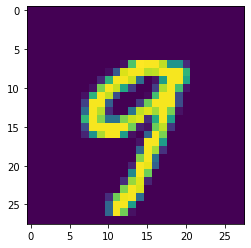

In [6]:
plt.imshow(new_train_images[5])
new_train_images.shape

##Load and prepare the dataset

#Code for dataset contaning only the 9th digit (Dataset a)

In [7]:
def miniDataset(new_train_images , new_train_labels):
    new_train_images = new_train_images.reshape(new_train_images.shape[0], 28, 28, 1).astype('float32')
    new_train_images = (new_train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

    BUFFER_SIZE = new_train_images.shape[0]
    BATCH_SIZE = 16

    train_dataset = tf.data.Dataset.from_tensor_slices((new_train_images,new_train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_dataset , BATCH_SIZE

#Code for loading the whole dataset (Dataset b)

In [8]:
def bigDataset(train_images , train_labels):
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

    BATCH_SIZE = 16

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_dataset , BATCH_SIZE

In [9]:
data_input = input('enter the dataset you want use (a/b) : ')

enter the dataset you want use (a/b) : a


In [10]:
if data_input == 'a':
    train_dataset , BATCH_SIZE  = miniDataset(new_train_images , new_train_labels)
else:
    train_dataset , BATCH_SIZE = bigDataset(train_images , train_labels)

In [11]:
for train_image , train_label in train_dataset:
    print(train_label[1])
    break

tf.Tensor(9, shape=(), dtype=uint8)


##Creating generator model

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model


##Creating an instance of the model,and then giving noise vector to our generator.

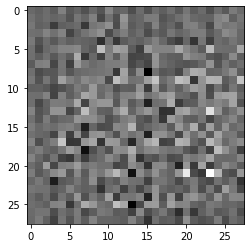

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])#giving random input vector
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')#printing the generated image by the generator from the rando vector

##Creating discriminator,which just classify fake and real images.

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

##Creating an instance of discriminator,and then giving the output of the generator to discriminator to see the prediction,it will give negative value for the fake image and positive value for the real image.

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image) #giving the generated image to discriminator,the discriminator will give negative value if it is fake,while if it is real then it will give positive value.
print (decision)

tf.Tensor([[-0.00162227]], shape=(1, 1), dtype=float32)


##Defining the binary cross entropy loss function for the mdels.

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)#creating loss function

#The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(generated_output):
    return cross_entropy(tf.ones_like(generated_output),generated_output)

#This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.





In [18]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = cross_entropy(tf.zeros_like(generated_output),generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

##Defining the optimizer for both the models.

In [19]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

##Defining the variables for the training purpose.

In [20]:
# checkpoint_dir = './training_checkpoints'
checkpoint_dir = '/content/drive/My Drive/GAN/Checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, noise_dim])

##Defining the train step function which will take images as parameter and then provide it to the discriminator. 

In [22]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])#creating a noise vector.

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #defining two gradient tape one for generator and other for discriminator.
      generated_images = generator(noise, training=True)#giving generator the noise vector.

      real_output = discriminator(images, training=True)#now the real output will be from the real image which is our dataset image.
      fake_output = discriminator(generated_images, training=True)#now the fake output will be from the generated images .

      gen_loss = generator_loss(fake_output)#giving fake output for generator loss.
      disc_loss = discriminator_loss(real_output, fake_output)#discriminator will have two losses,one correspond to real loss and other is fake loss.

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#calculating gradients for generator.
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)#calculating gradients for generator.

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#providing the gradient to the generator optimizer.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))#providing the gradient to the discriminator optimizer.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [26]:
cd '/content/drive/My Drive/GAN'

/content/drive/My Drive/GAN


##Defining the train function to train our models,and saving the images for each epoch.

In [27]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  
  generate_and_save_images(generator,
                           epochs,
                           seed)

##Saving the model

In [28]:

take_input = input('Is it the first time you are running the model (y/n) : ')

Is it the first time you are running the model (y/n) : y


In [29]:
if take_input == 'y':
    file = open('runtime_count.txt' , 'w')
    count = 1
    flag = 0
    file.write(str(count))
    file.close()


    def generate_and_save_images(model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            # plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        file = open('epoch_count.txt' , 'w')
        file.write(str(epoch))
        file.close()
        plt.savefig('{}_image_at_epoch_{:01d}.png'.format(count , epoch))
        plt.show()
else:
    #run this code only if there is a runtime disconnection
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    flag = 1

In [30]:

#run this code only if there is a runtime disconnection
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# flag = 1

In [31]:
if flag == 1:
    file = open('runtime_count.txt', 'r')
    doc = file.read()
    file.close()

    file_1 = open('epoch_count.txt', 'r')
    doc_1 = file_1.read()
    file_1.close()

    count_new = int(doc) + 1
    def generate_and_save_images(model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            # plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        epoch = epoch + int(doc_1)
        file = open('epoch_count.txt' , 'w')
        file.write(str(epoch))
        file.close()
        plt.savefig('{}_image_at_epoch_{:01d}.png'.format(count_new , epoch))
        plt.show()

    file = open('runtime_count.txt' , 'w')
    file.write(str(count_new))
    file.close()
else:
    print('the code is running for the first time')

the code is running for the first time


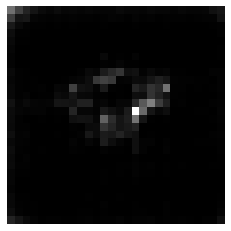

Time for epoch 1 is 24.526233911514282 sec


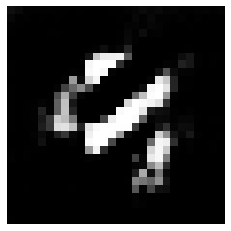

Time for epoch 2 is 28.8479163646698 sec


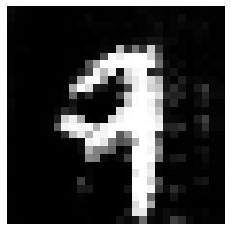

Time for epoch 3 is 23.680742502212524 sec


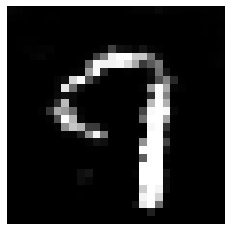

Time for epoch 4 is 24.57154870033264 sec


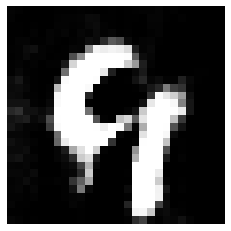

Time for epoch 5 is 23.528943061828613 sec


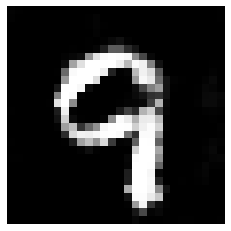

Time for epoch 6 is 24.892998933792114 sec


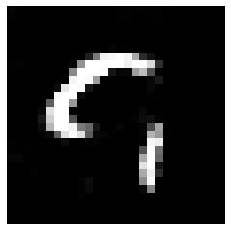

Time for epoch 7 is 23.720672130584717 sec


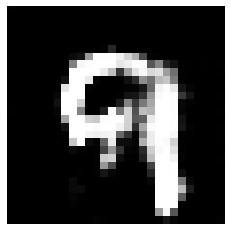

Time for epoch 8 is 24.604732751846313 sec


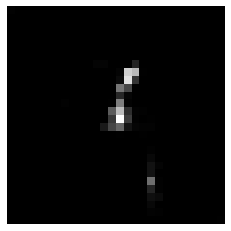

Time for epoch 9 is 29.824711322784424 sec


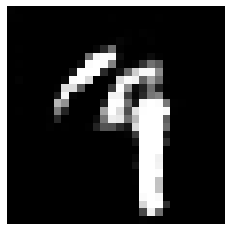

Time for epoch 10 is 24.709939002990723 sec


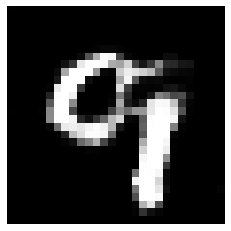

Time for epoch 11 is 23.757299423217773 sec


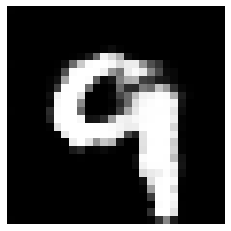

Time for epoch 12 is 24.639103412628174 sec


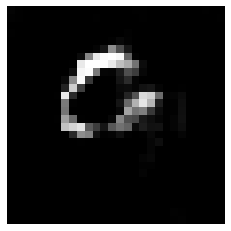

Time for epoch 13 is 23.80474042892456 sec


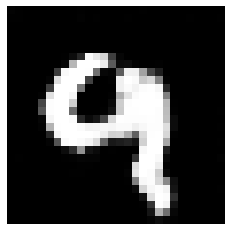

Time for epoch 14 is 24.581000089645386 sec


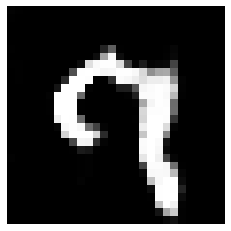

Time for epoch 15 is 23.856874704360962 sec


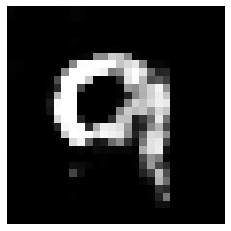

Time for epoch 16 is 24.559916734695435 sec


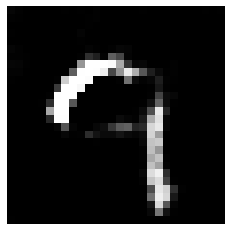

Time for epoch 17 is 23.610069751739502 sec


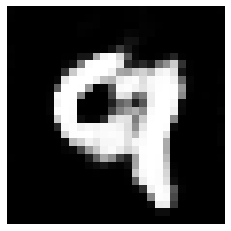

Time for epoch 18 is 24.625237464904785 sec


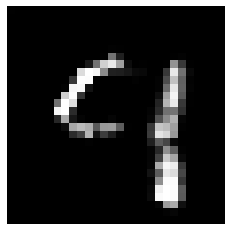

Time for epoch 19 is 23.86994743347168 sec


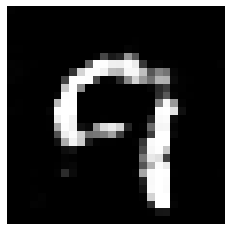

Time for epoch 20 is 24.60298204421997 sec


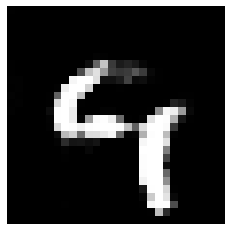

Time for epoch 21 is 23.576786756515503 sec


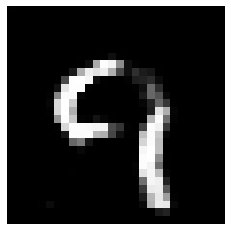

Time for epoch 22 is 24.617580890655518 sec


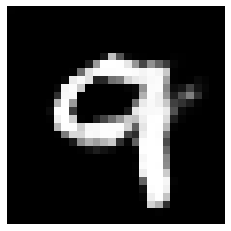

Time for epoch 23 is 23.68673586845398 sec


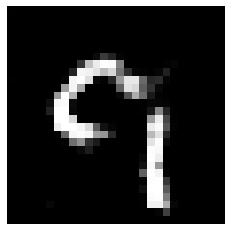

Time for epoch 24 is 24.52763342857361 sec


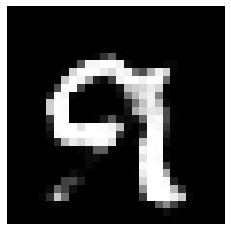

Time for epoch 25 is 23.56694984436035 sec


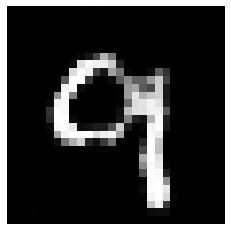

Time for epoch 26 is 24.544835090637207 sec


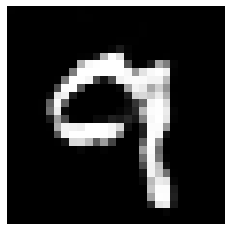

Time for epoch 27 is 23.765249729156494 sec


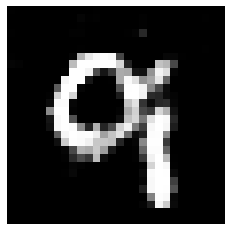

Time for epoch 28 is 24.403506755828857 sec


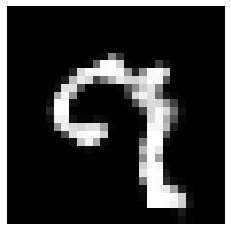

Time for epoch 29 is 23.65864872932434 sec


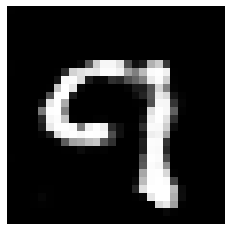

Time for epoch 30 is 24.38823366165161 sec


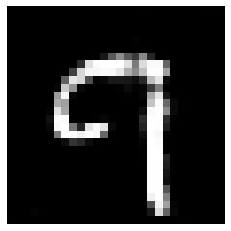

Time for epoch 31 is 23.663429498672485 sec


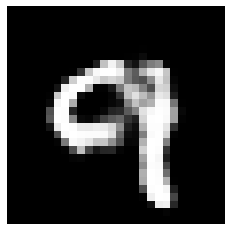

Time for epoch 32 is 24.697631120681763 sec


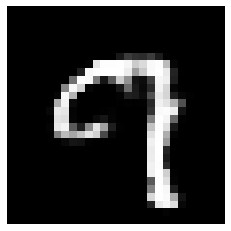

Time for epoch 33 is 23.57087254524231 sec


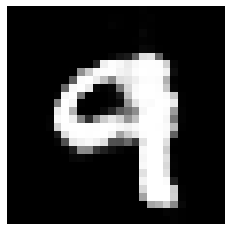

Time for epoch 34 is 24.495970487594604 sec


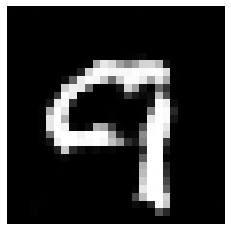

Time for epoch 35 is 23.611643075942993 sec


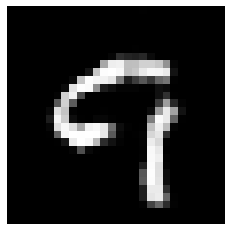

Time for epoch 36 is 24.427587270736694 sec


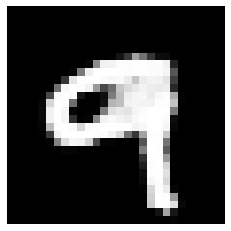

Time for epoch 37 is 23.650562047958374 sec


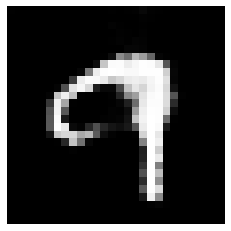

Time for epoch 38 is 24.445932388305664 sec


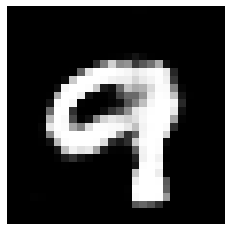

Time for epoch 39 is 23.682624578475952 sec


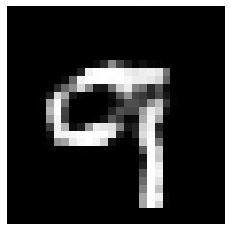

Time for epoch 40 is 24.326645851135254 sec


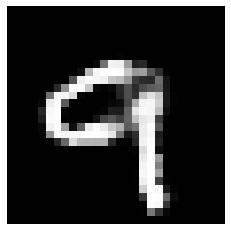

Time for epoch 41 is 23.43562960624695 sec


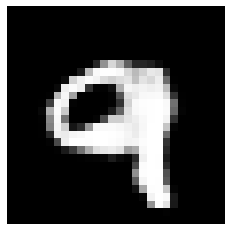

Time for epoch 42 is 24.502541303634644 sec


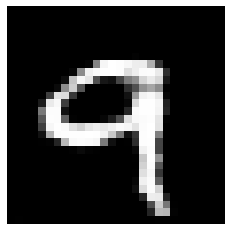

Time for epoch 43 is 23.472407579421997 sec


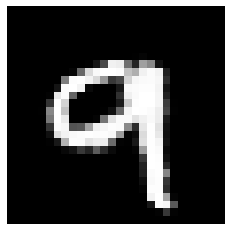

Time for epoch 44 is 24.72879147529602 sec


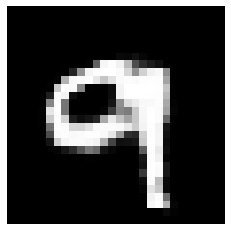

Time for epoch 45 is 23.59984016418457 sec


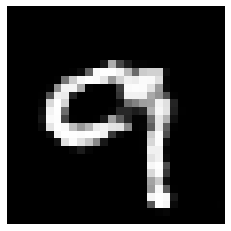

Time for epoch 46 is 24.502618312835693 sec


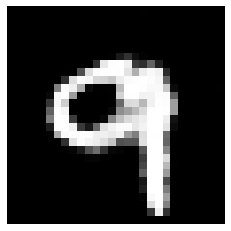

Time for epoch 47 is 23.658326148986816 sec


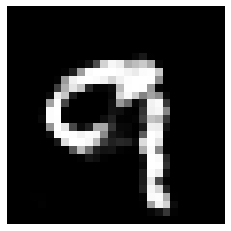

Time for epoch 48 is 24.42168354988098 sec


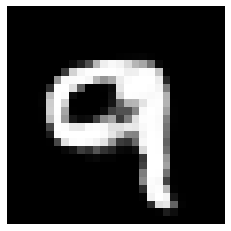

Time for epoch 49 is 23.685004949569702 sec


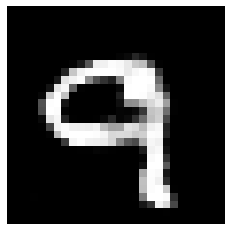

Time for epoch 50 is 24.3912296295166 sec


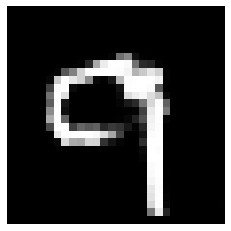

Time for epoch 51 is 23.55669665336609 sec


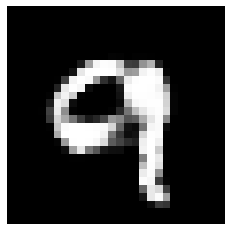

Time for epoch 52 is 24.541356563568115 sec


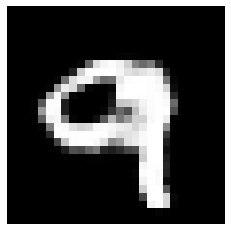

Time for epoch 53 is 23.616309881210327 sec


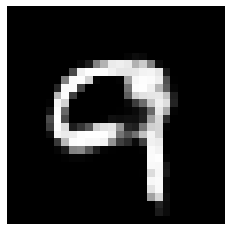

Time for epoch 54 is 26.339681386947632 sec


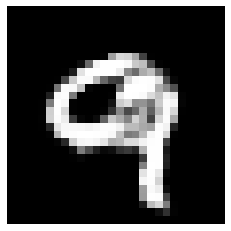

Time for epoch 55 is 23.465498208999634 sec


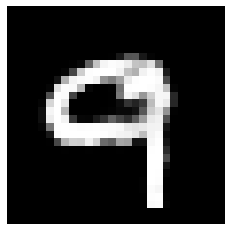

Time for epoch 56 is 24.43107295036316 sec


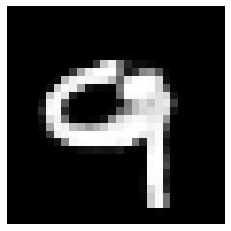

Time for epoch 57 is 23.599183082580566 sec


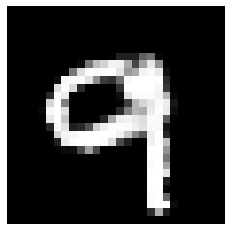

Time for epoch 58 is 24.926522493362427 sec


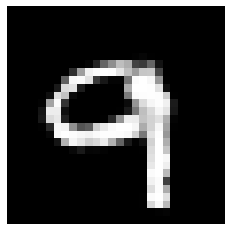

Time for epoch 59 is 23.302557229995728 sec


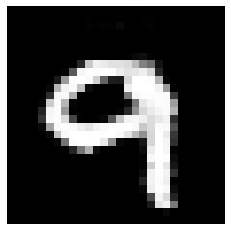

Time for epoch 60 is 24.21631932258606 sec


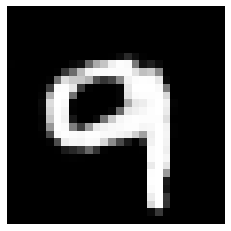

Time for epoch 61 is 23.600104808807373 sec


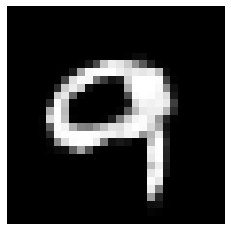

Time for epoch 62 is 24.355528354644775 sec


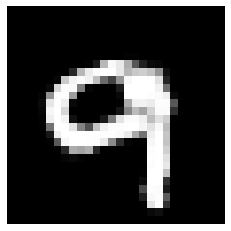

Time for epoch 63 is 23.51645064353943 sec


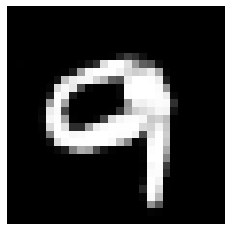

Time for epoch 64 is 24.623265743255615 sec


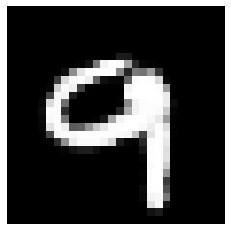

Time for epoch 65 is 23.63286828994751 sec


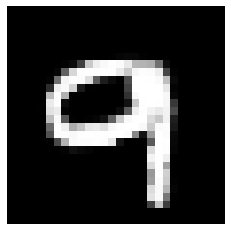

Time for epoch 66 is 24.364114999771118 sec


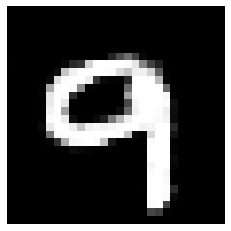

Time for epoch 67 is 23.511945247650146 sec


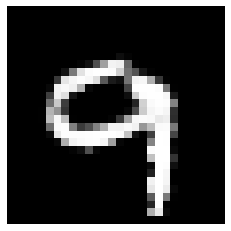

Time for epoch 68 is 24.34169578552246 sec


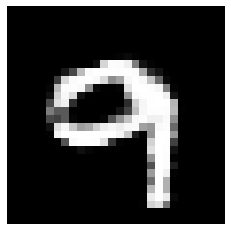

Time for epoch 69 is 23.550142765045166 sec


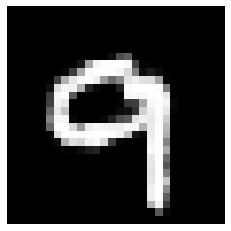

Time for epoch 70 is 24.46172070503235 sec


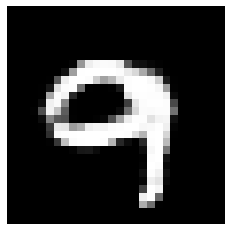

Time for epoch 71 is 23.3490149974823 sec


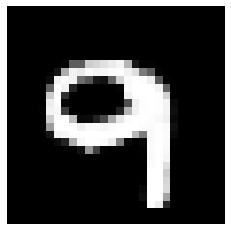

Time for epoch 72 is 24.1592698097229 sec


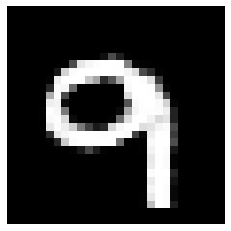

Time for epoch 73 is 23.33223032951355 sec


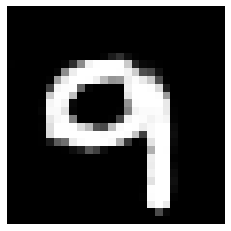

Time for epoch 74 is 24.278019189834595 sec


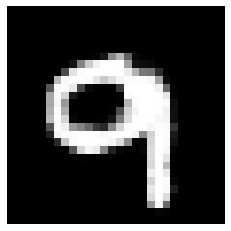

Time for epoch 75 is 23.28245759010315 sec


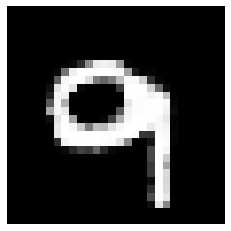

Time for epoch 76 is 24.21422290802002 sec


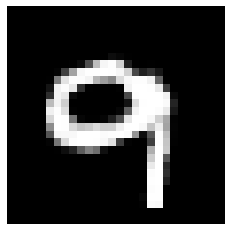

Time for epoch 77 is 23.40411925315857 sec


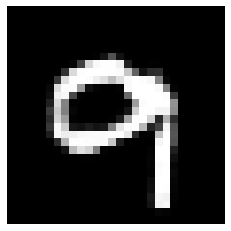

Time for epoch 78 is 24.466625928878784 sec


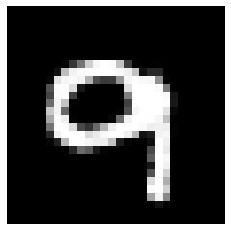

Time for epoch 79 is 23.457247495651245 sec


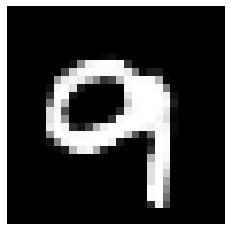

Time for epoch 80 is 24.38496685028076 sec


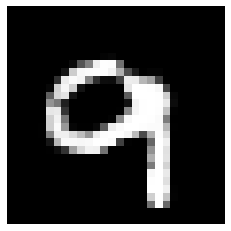

Time for epoch 81 is 23.54829216003418 sec


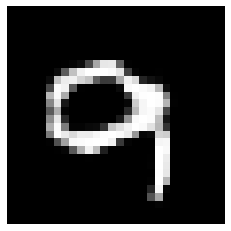

Time for epoch 82 is 24.2465980052948 sec


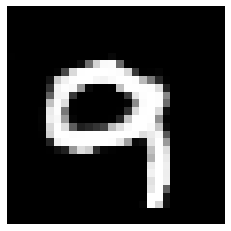

Time for epoch 83 is 23.73922038078308 sec


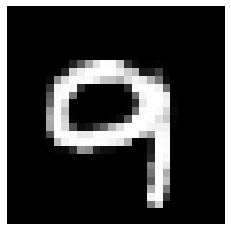

Time for epoch 84 is 24.469741344451904 sec


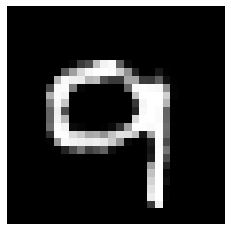

Time for epoch 85 is 23.527740955352783 sec


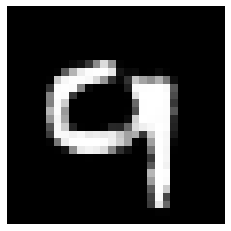

Time for epoch 86 is 24.318175077438354 sec


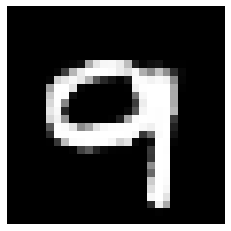

Time for epoch 87 is 23.41975474357605 sec


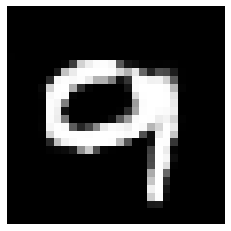

Time for epoch 88 is 24.494434118270874 sec


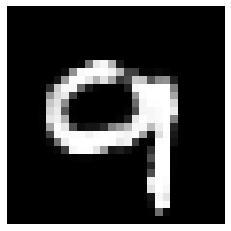

Time for epoch 89 is 23.456823110580444 sec


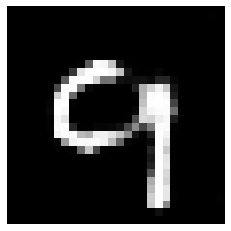

Time for epoch 90 is 24.409038066864014 sec


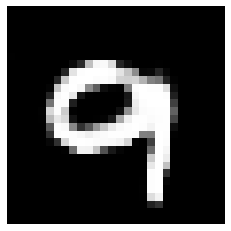

Time for epoch 91 is 23.79207944869995 sec


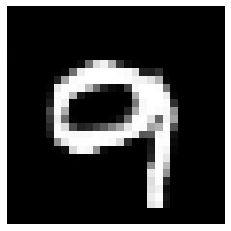

Time for epoch 92 is 24.277063369750977 sec


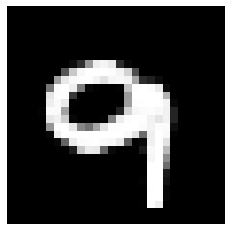

Time for epoch 93 is 23.542724609375 sec


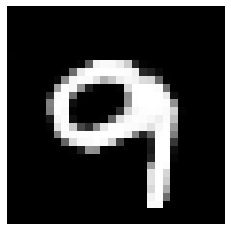

Time for epoch 94 is 24.18808388710022 sec


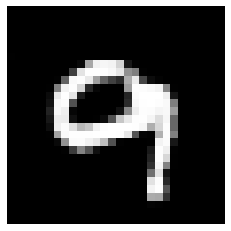

Time for epoch 95 is 23.566143035888672 sec


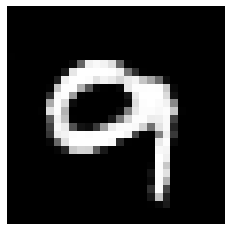

Time for epoch 96 is 24.552759408950806 sec


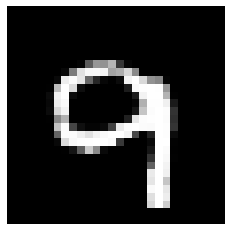

Time for epoch 97 is 23.432836294174194 sec


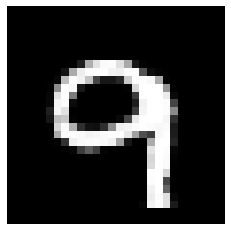

Time for epoch 98 is 24.41472315788269 sec


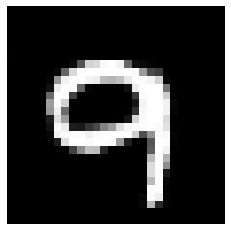

Time for epoch 99 is 23.477126359939575 sec


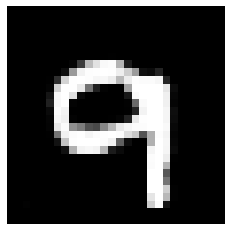

Time for epoch 100 is 24.089056253433228 sec


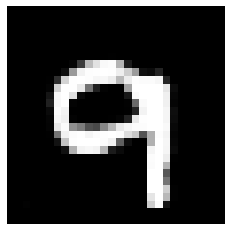

In [32]:
train(train_dataset, EPOCHS)

#References
https://github.com/whoIsTheGingerBreadMan/YoutubeVideos

https://www.tensorflow.org/tutorials/generative/dcgan

